In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import config

/home/abian/Workspace/Anaconda/envs/ResearchStay/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
from dataset import JasperRidge
dataset = JasperRidge(config.JasperRidge_PATH)

In [23]:
# read data from matlab
files = os.listdir(config.RESULTS_PATH)
matlab_files = list(map(lambda x: os.path.join(config.RESULTS_PATH, x), files))

from scipy.io import loadmat
matlab_data = loadmat(matlab_files[3])
matlab_data.keys()

['/home/abian/Workspace/Thesis/IUMA/ContrastiveLearningUnmixing/notebooks/../data/results/ab_ppi_x.mat', '/home/abian/Workspace/Thesis/IUMA/ContrastiveLearningUnmixing/notebooks/../data/results/ab_avmax_x.mat', '/home/abian/Workspace/Thesis/IUMA/ContrastiveLearningUnmixing/notebooks/../data/results/ab_vca_x.mat', '/home/abian/Workspace/Thesis/IUMA/ContrastiveLearningUnmixing/notebooks/../data/results/ab_nfindr_x.mat', '/home/abian/Workspace/Thesis/IUMA/ContrastiveLearningUnmixing/notebooks/../data/results/em_x.mat', '/home/abian/Workspace/Thesis/IUMA/ContrastiveLearningUnmixing/notebooks/../data/results/ab_atgp_x.mat']


dict_keys(['__header__', '__version__', '__globals__', 'abFclsM', 'abNnlsM', 'abUclsM', 'em'])

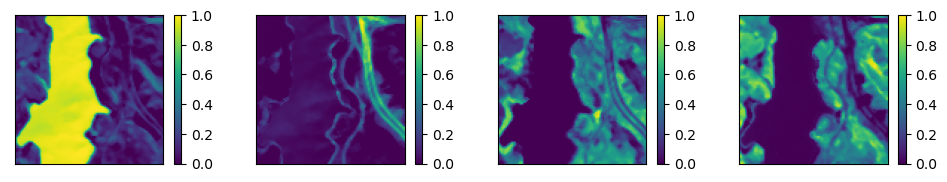

In [20]:
abundance = matlab_data['abFclsM']
n_endmembers = 4
# plot

with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(12,7))
    for i in range(n_endmembers):
        plt.subplot(4,5,i+1)
        plt.imshow(abundance[:,:,i].T, vmin=0, vmax=1)
        # plt.imshow(abundance[:,:,i].T)
        plt.xticks([])
        plt.yticks([])
        # plt.title(labels[i], fontsize='x-large')
        plt.colorbar()

    plt.tight_layout()
    plt.show()

# plt.figure(figsize=(12,7))
# for i in range(4):
#     plt.subplot(1,4,i+1)
#     plt.imshow(abundance[:,:,i].T, cmap='viridis')
#     plt.colorbar()
# plt.show()

In [6]:
abundance.shape

(100, 100, 4)

In [3]:
# get the path of the current file
current_path = os.path.dirname(os.path.abspath('__file__'))
print(current_path)

/home/abian/Workspace/Thesis/IUMA/ContrastiveLearningUnmixing/notebooks


In [4]:
config.RESULTS_PATH

'/home/abian/Workspace/Thesis/IUMA/ContrastiveLearningUnmixing/notebooks/../data/results/'